### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

import sys
sys.path.insert(1, '../')

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [3]:
bank_df = pd.read_csv('../data/bank-additional-full.csv', sep=';')

X_bank=bank_df.drop(columns='y')
y_bank=(bank_df['y'] == 'yes').astype(int)

prep_bank = Preprocessor()

In [5]:
X_bank_train, X_bank_test, y_bank_train, y_bank_test = prep_bank.train_test_split(X_bank, y_bank)

In [6]:
X_train=X_bank_train.copy()
X_test=X_bank_test.copy()
y_train=y_bank_train.copy()
y_test=y_bank_test.copy()

#One Hot Encoding
X_train = prep_bank.one_hot_encoding_fit_transform(X_train)
X_test = prep_bank.one_hot_encoding_transform(X_test)

#Collinearities removal
X_train = prep_bank.remove_multicollinearity_fit_transform(X_train)
X_test = prep_bank.remove_multicollinearity_transform(X_test)

#X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
#X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

/home/pawel/.local/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


42 numerical features left in dataset  0  categorical


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [7]:
lr=0.01
n_epochs=10

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

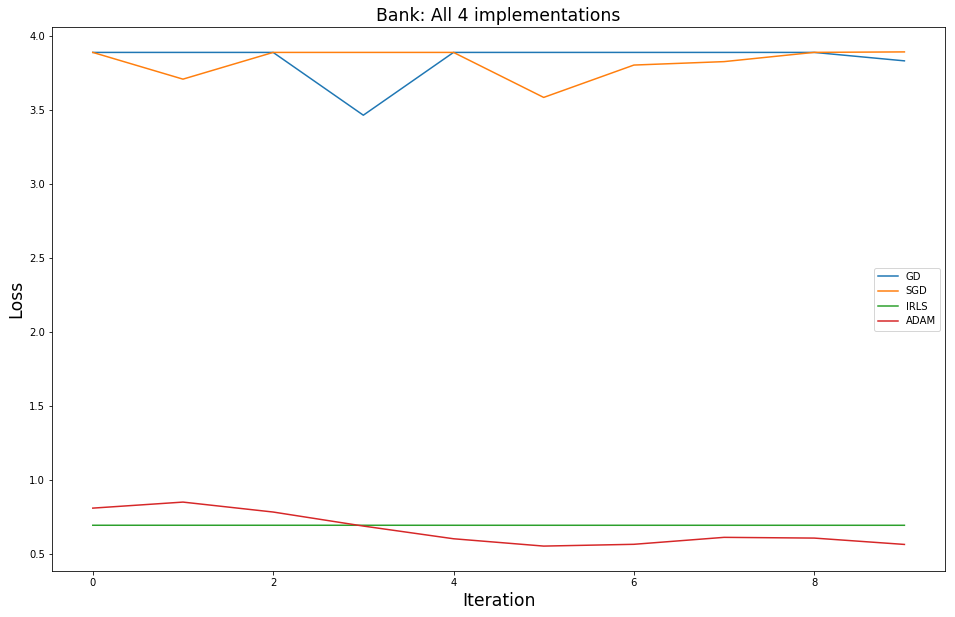

In [17]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train.to_numpy(), y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('Bank: All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('Bank_conv_01.svg')
plt.show()

#### 1(b)

In [42]:
y_train_2=y_bank_train.copy()
y_test_2=y_bank_test.copy()

# Rebalancing the training dataset
X_train_2, y_train_2 = prep_bank.class_balancing(X_train, y_train_2)

#Scaling the dataset
s = StandardScaler()
X_train_3 = s.fit_transform(X_train_2)
X_test_3 = s.transform(X_test)
y_train_2 = y_train_2.to_numpy()
y_train_3 = y_train_2.copy()
y_test_3 = y_test.copy()

Training dataset has now  54822 obervations. 50.0  percent is in positive group.


Only target balancing:

In [10]:
lr_models_2 = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

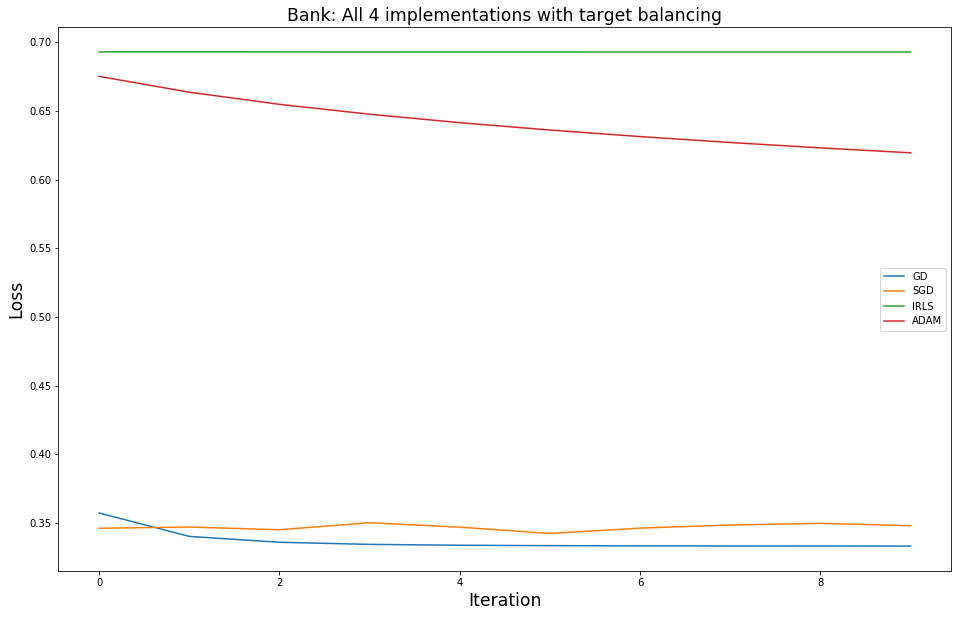

In [11]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models_2.items():
    model.train(X_train_2, y_train_2)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('Bank: All 4 implementations with target balancing',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('Bank_conv_02.svg')
plt.show()

Target balancing and data scaling

In [14]:
lr_models_3 = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

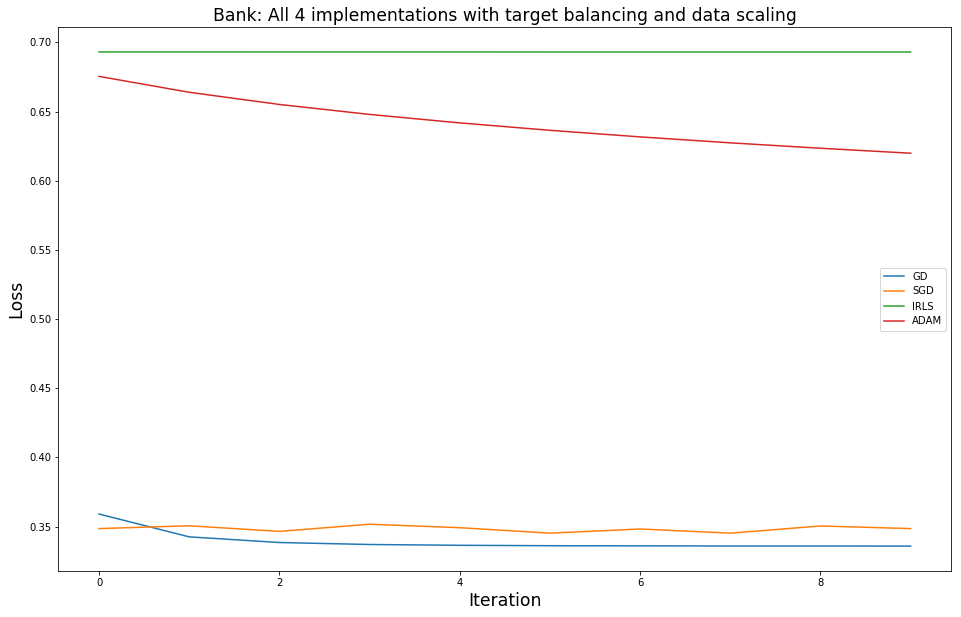

In [43]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models_3.items():
    model.train(X_train_3, y_train_3)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('Bank: All 4 implementations with target balancing and data scaling',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('Bank_conv_03.svg')
plt.show()

In [44]:
comp_df = pd.DataFrame(columns=['algorithm', 'transform', 'f_score'])
for model_name in lr_models:
    f_no_scal = measures.f_measure(lr_models[model_name].predict(X_test), y_test)
    f_balanced = measures.f_measure(lr_models_2[model_name].predict(X_test), y_test)
    f_scaled = measures.f_measure(lr_models_3[model_name].predict(X_test_3), y_test_3)
    comp_df = pd.concat((comp_df, pd.DataFrame({'algorithm': [model_name]*3,
                                                'transform': ['None', 'Balancing', 'Balancing & scaling'],
                                                'f_score': [f_no_scal, f_balanced, f_scaled]})),
                        ignore_index=True)

../measures.py:50: RuntimeWarning: invalid value encountered in double_scalars
  acc=accuracy(y_pred, y_test)


In [45]:
comp_df

,algorithm,transform,f_score
0,GD,None,NaN
1,GD,Balancing,0.202496
2,GD,Balancing & scaling,0.581462
3,SGD,None,0.433962
4,SGD,Balancing,0.202496
5,SGD,Balancing & scaling,0.573670
6,IRLS,None,0.438566
7,IRLS,Balancing,0.202496
8,IRLS,Balancing & scaling,0.576119
9,ADAM,None,NaN


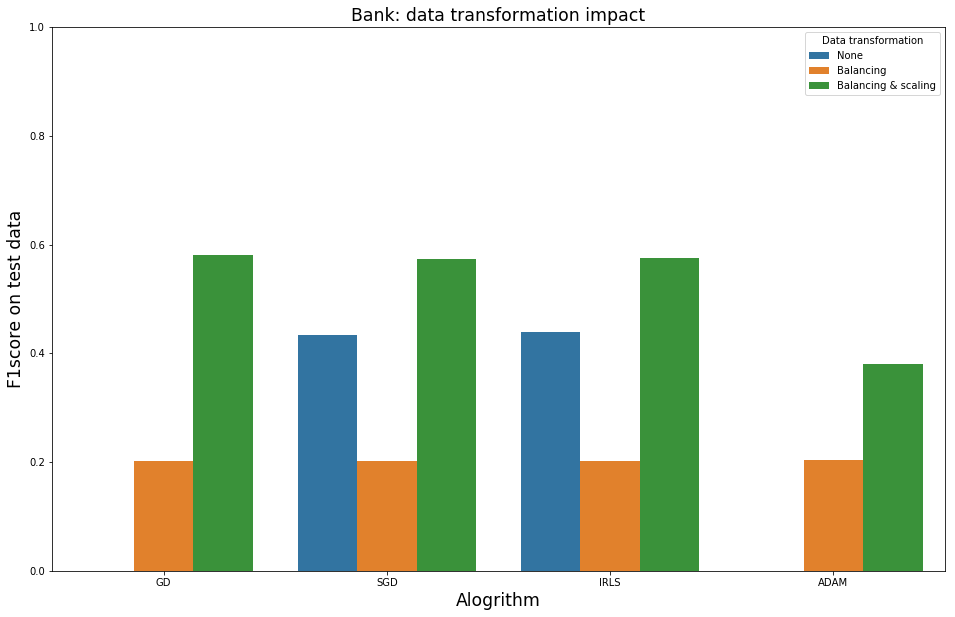

In [46]:
plt.figure(figsize=(16, 10))
sns.barplot(x='algorithm', y='f_score', data=comp_df, hue='transform')
plt.legend(loc=1, title='Data transformation')
plt.ylim(0, 1)
plt.title('Bank: data transformation impact', fontsize='xx-large')
plt.xlabel('Alogrithm', fontsize='xx-large')
plt.ylabel('F1score on test data', fontsize='xx-large')
plt.savefig('Bank_transformation_impact.svg')
plt.show()

No doubt on the best data transformation combination

#### 2. Check how the value of learning rate and other parameters affect the results.

In [49]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=6)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}

res_test_learning_rates=experiments.test_learning_rates(X_train=X_train_3,
                                                        y_train=y_train_3,
                                                        X_test=X_test_3,
                                                        y_test=y_test_3,
                                                        l_rates=tested_l_rates,
                                                        algorithms=tested_algorithms,
                                                        n_epochs=50
                                                       )

res_test_learning_rates

,learning_rate,method,accuracy,recall,precision,F_measure
0,0.200000,GD,0.860,0.861,0.438,0.581
1,0.200000,SGD,0.827,0.870,0.382,0.531
2,0.200000,ADAM,0.860,0.865,0.439,0.582
3,0.160002,GD,0.859,0.865,0.436,0.580
4,0.160002,SGD,0.829,0.868,0.385,0.533
5,0.160002,ADAM,0.860,0.854,0.439,0.580
6,0.120004,GD,0.858,0.866,0.434,0.579
7,0.120004,SGD,0.832,0.872,0.390,0.539
8,0.120004,ADAM,0.860,0.840,0.437,0.575
9,0.080006,GD,0.859,0.868,0.436,0.580


In [50]:
res_test_learning_rates.sort_values(['method', 'accuracy', 'F_measure'], ascending=[True, False, False])\
                       .groupby('method').head(2)

,learning_rate,method,accuracy,recall,precision,F_measure
2,0.200000,ADAM,0.860,0.865,0.439,0.582
5,0.160002,ADAM,0.860,0.854,0.439,0.580
0,0.200000,GD,0.860,0.861,0.438,0.581
3,0.160002,GD,0.859,0.865,0.436,0.580
16,0.000010,SGD,0.862,0.860,0.443,0.585
13,0.040008,SGD,0.841,0.883,0.406,0.556


Very small value of optimal learning rate of SGD draws attention.

In [ ]:
tested_betas_1=np.linspace(start=0.75,stop=.97,num=12)
tested_betas_2=np.linspace(start=0.90,stop=0.99,num=10)
tested_lr = [0.2, 0.1, 0.02]

res_test_betas=experiments.test_betas(X_train=X_train_3, 
                                      y_train=y_train_3,
                                      X_test=X_test_3,
                                      y_test=y_test_3,
                                      tested_betas1=tested_betas_1,
                                      tested_betas2=tested_betas_2,
                                      learning_rates=tested_lr)

res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

#### 4. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

In [ ]:
lr=0.001
n_epochs=1000
models = {
    'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
    'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.8,
                   beta_2=0.98, epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}

In [ ]:
res_final=experiments.final_comparisson(X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test,
                                        y_test=y_test,
                                        models=models)

res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)